In [3]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
import copy
import matplotlib.pyplot as plt

import proper
proper.prop_use_fftw(DISABLE=True)

import roman_phasec_proper
roman_phasec_proper.copy_here()

import misc
from matplotlib.patches import Circle

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 825e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

# define desired PSF dimensions and pixelscale in units of lambda/D
npsf = 150

# psf_pixelscale = 13e-6
# psf_pixelscale_lamD = 500/825 * 1/2
# psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

psf_pixelscale_mas = 20.8*u.mas/u.pix
psf_pixelscale_lamD = psf_pixelscale_mas.value / mas_per_lamD.value
psf_pixelscale = 13e-6 * psf_pixelscale_lamD/(1/2)

polaxis = 10
print(psf_pixelscale_lamD, psf_pixelscale_mas, psf_pixelscale)

iwa = 6
owa = 20

0.2888459971450042 20.8 mas / pix 7.509995925770108e-06


(105,) [ 0.          0.144423    0.288846    0.433269    0.57769199  0.72211499
  0.86653799  1.01096099  1.15538399  1.29980699  1.44422999  1.58865298
  1.73307598  1.87749898  2.02192198  2.16634498  2.31076798  2.45519098
  2.59961397  2.74403697  2.88845997  3.03288297  3.17730597  3.32172897
  3.46615197  3.61057496  3.75499796  3.89942096  4.04384396  4.18826696
  4.33268996  4.47711296  4.62153595  4.76595895  4.91038195  5.05480495
  5.19922795  5.34365095  5.48807395  5.63249694  5.77691994  5.92134294
  6.06576594  6.21018894  6.35461194  6.49903494  6.64345793  6.78788093
  6.93230393  7.          7.288846    7.57769199  7.86653799  8.15538399
  8.44422999  8.73307598  9.02192198  9.31076798  9.59961397  9.88845997
 10.17730597 10.46615197 10.75499796 11.04384396 11.33268996 11.62153595
 11.91038195 12.19922795 12.48807395 12.77691994 13.06576594 13.35461194
 13.64345793 13.93230393 14.22114993 14.50999593 14.79884192 15.08768792
 15.37653392 15.66537991 15.95422591 16.2430

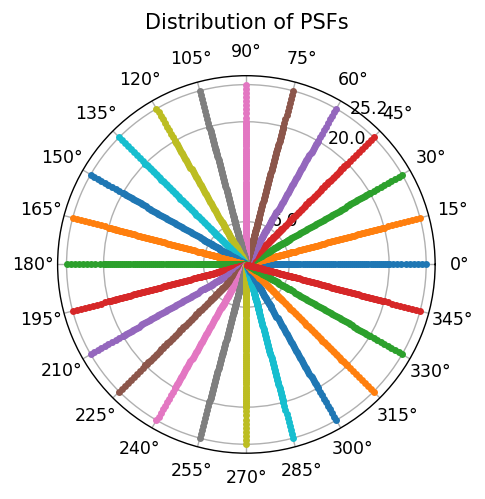

In [17]:
# Create the sampling grid the PSFs will be made on
sampling1 = psf_pixelscale_lamD/2
sampling2 = psf_pixelscale_lamD
sampling3 = 2*psf_pixelscale_lamD
offsets1 = np.arange(0,iwa+1,sampling1)
offsets2 = np.arange(iwa+1,owa,sampling2)
offsets3 = np.arange(owa,owa+5+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
r_offsets_mas = r_offsets*mas_per_lamD
print(r_offsets.shape, r_offsets)

sampling_theta = 15
thetas = np.arange(0,360,sampling_theta)*u.deg
print(thetas.shape, thetas)

psfs_required = len(thetas)*len(r_offsets)
print(psfs_required)

r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
r_offsets_fpath = data_dir/'psfs'/'spcw_band4_psfs_radial_samples.fits'
r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

thetas_hdu = fits.PrimaryHDU(data=thetas.value)
thetas_fpath = data_dir/'psfs'/'spcw_band4_psfs_theta_samples.fits'
thetas_hdu.writeto(thetas_fpath, overwrite=True)

# Plotting field angles
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=125)
ax.plot(theta_offsets, r_offsets[1:], '.')
ax.set_rticks([iwa, owa, max(r_offsets)])  # Less radial ticks
ax.set_thetagrids(thetas.value)
ax.set_rlabel_position(55)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_title('Distribution of PSFs', va='bottom')
plt.show()

In [21]:
10/658 * 2520

38.297872340425535

In [6]:
nlam = 5
lam0 = 0.825
if nlam==1:
    lam_array = np.array([lam0])
else:
    bandwidth = 0.1
    minlam = lam0 * (1 - bandwidth/2)
    maxlam = lam0 * (1 + bandwidth/2)
    lam_array = np.linspace( minlam, maxlam, nlam )

dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm1.fits' )
dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/spc_wide_band4_best_contrast_dm2.fits' )

options = {'cor_type':'spc-wide', # change coronagraph type to correct band
           'final_sampling_lam0':psf_pixelscale_lamD, 
           'source_x_offset':0,
           'source_y_offset':0,
           'use_fpm':1,
           'use_field_stop':1,
           'use_errors':1,
           'use_lens_errors':1,
           'use_hlc_dm_patterns':0,
           'use_dm1':1, 'dm1_m':dm1, 
           'use_dm2':1, 'dm2_m':dm2,
           'polaxis':polaxis,   
          }

Lambda = 7.8375E-07   Throughput = 1.00Lambda = 8.4562E-07   Throughput = 1.00Lambda = 8.0437E-07   Throughput = 1.00Lambda = 8.2500E-07   Throughput = 1.00Lambda = 8.6625E-07   Throughput = 1.00




Applying lens
Applying lens
Applying lensApplying lens

Applying lens
Propagating to secondary
Propagating to secondary
Propagating to secondary
Propagating to secondaryPropagating to secondary

Applying lens
Applying lens
Applying lens
Applying lens
Applying lens
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to POMA FOLD
Propagating to M3Propagating to M3

Propagating to M3
Propagating to M3
Propagating to M3
Applying lens
Applying lens
Applying lens
Applying lens
Applying lens
Propagating to M4
Propagating to M4
Propagating to M4
Propagating to M4
Propagating to M4
Applying lens
Applying lens
Applying lens
Applying lens
Applying lens
Propagating to M5
Propagating to M5
Propagating to M5
Propagating to M5
Propagating to M5


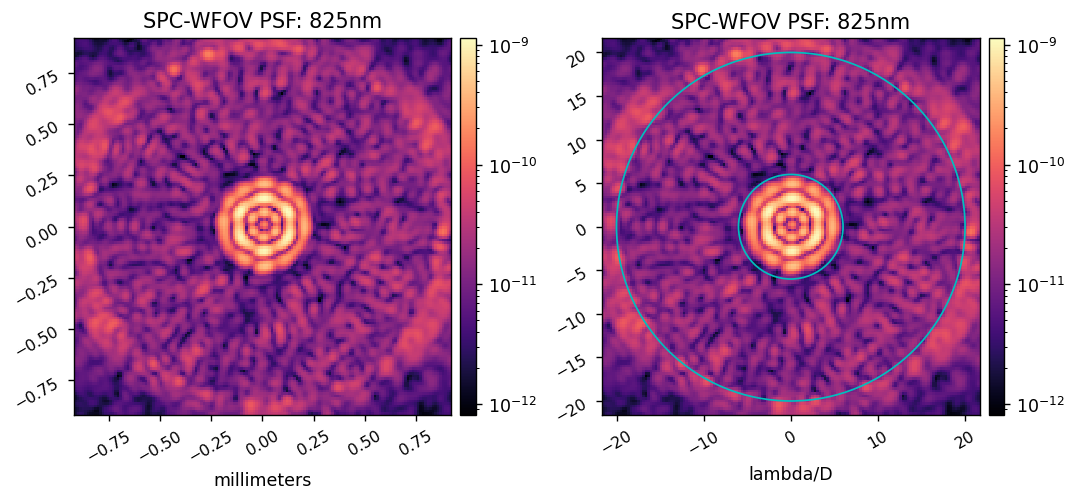

In [7]:
(wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, 256, QUIET=False, PASSVALUE=options)

psfs = np.abs(wfs)**2
psf_bb = misc.pad_or_crop(np.sum(psfs, axis=0)/nlam, npsf)
psf_pixelscale_m = pxscls_m[0]*u.m/u.pix

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow2(psf_bb, psf_bb, 'SPC-WFOV PSF: 825nm', 'SPC-WFOV PSF: 825nm',
               lognorm1=True, lognorm2=True, 
               pxscl1=psf_pixelscale_m.to(u.mm/u.pix), pxscl2=psf_pixelscale_lamD, patches2=patches)

In [14]:
psfs_array = np.zeros( shape=( (len(r_offsets)-1)*len(thetas) + 1, npsf,npsf) )

count = 0
start = time.time()
for i,r in enumerate(r_offsets): 
    opts = []
    for j,th in enumerate(thetas):
        xoff = r*np.cos(th)
        yoff = r*np.sin(th)
        options.update( {'source_x_offset':xoff.value, 'source_y_offset':yoff.value} )
    
#         (wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, 256, QUIET=True, PASSVALUE=options)
#         psfs = np.abs(wfs)**2
#         psf = misc.pad_or_crop(np.sum(psfs, axis=0)/nlam, npsf)
        psf = np.ones((npsf,npsf))
        
        if r<r_offsets[1]: 
            psfs_array[0] = psf
            count += 1
            break
        else: 
            psfs_array[count] = psf
            
        print(count, time.time()-start)
        count += 1

1 0.0009016990661621094
2 0.0011599063873291016
3 0.0013308525085449219
4 0.0015633106231689453
5 0.0018351078033447266
6 0.0020072460174560547
7 0.002160787582397461
8 0.0023148059844970703
9 0.002465963363647461
10 0.0026192665100097656
11 0.0028905868530273438
12 0.0029916763305664062
13 0.0030913352966308594
14 0.0031900405883789062
15 0.003289461135864258
16 0.0033872127532958984
17 0.0034880638122558594
18 0.0035886764526367188
19 0.003688335418701172
20 0.003795146942138672
21 0.0038945674896240234
22 0.004145145416259766
23 0.004245758056640625
24 0.004343986511230469
25 0.004452943801879883
26 0.0045506954193115234
27 0.0046536922454833984
28 0.004751443862915039
29 0.004859209060668945
30 0.004958152770996094
31 0.005056619644165039
32 0.005155086517333984
33 0.005253791809082031
34 0.005505800247192383
35 0.0056056976318359375
36 0.005703926086425781
37 0.00580906867980957
38 0.00590825080871582
39 0.0060083866119384766
40 0.006106853485107422
41 0.00620579719543457
42 0.006

1733 0.20308971405029297
1734 0.2034132480621338
1735 0.2037196159362793
1736 0.2038402557373047
1737 0.20394134521484375
1738 0.20404314994812012
1739 0.20414447784423828
1740 0.20424485206604004
1741 0.204345703125
1742 0.20444655418395996
1743 0.20454621315002441
1744 0.20464658737182617
1745 0.20474791526794434
1746 0.20485544204711914
1747 0.20511913299560547
1748 0.20522260665893555
1749 0.2053236961364746
1750 0.20542311668395996
1751 0.20552492141723633
1752 0.2056255340576172
1753 0.205735445022583
1754 0.20584487915039062
1755 0.2059462070465088
1756 0.20604705810546875
1757 0.20615458488464355
1758 0.20642900466918945
1759 0.20653629302978516
1760 0.2066361904144287
1761 0.20673751831054688
1762 0.20684504508972168
1763 0.20694422721862793
1764 0.20704364776611328
1765 0.20714402198791504
1766 0.20724701881408691
1767 0.20734667778015137
1768 0.20744681358337402
1769 0.20754742622375488
1770 0.20782470703125
1771 0.20792937278747559
1772 0.20803260803222656
1773 0.2081341743

KeyboardInterrupt: 

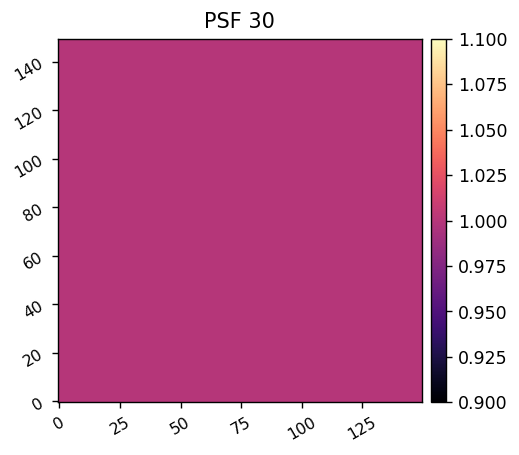

In [12]:
for i in range(psfs_array.shape[0]):
    clear_output(wait=True)
    misc.myimshow(psfs_array[i], 'PSF {:d}'.format(i), lognorm=False)
    time.sleep(0.5)

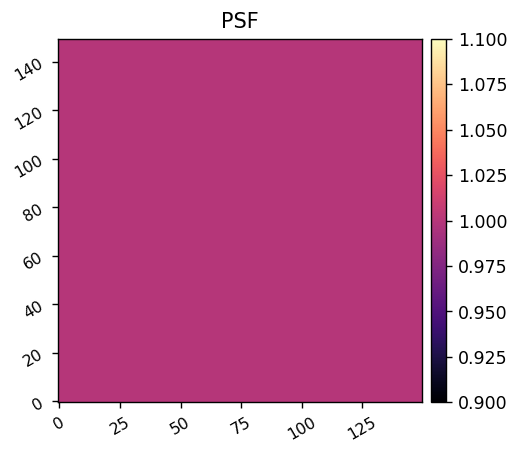

In [16]:
misc.myimshow(psfs_array[-1], 'PSF'.format(i), lognorm=False)

In [9]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale_m.value
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['CWAVELEN'] = wavelength_c.value
hdr.comments['CWAVELEN'] = 'central wavelength in meters'
hdr['BANDPASS'] = 0
hdr.comments['BANDPASS'] = 'bandpass as fraction of CWAVELEN'
hdr['POLAXIS'] = polaxis
hdr.comments['POLAXIS'] = 'polaxis: defined by roman_phasec_proper'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'hlc_band1_psfs_072022.fits'
psfs_hdu.writeto(psfs_fpath, overwrite=True)